# 04. Pytorch Computer Vision with Custom Dataset

Reference Video: https://youtu.be/Z_ikDlimN6A?t=71030

Reference Book: https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [1]:
import torch
from torch import nn

In [2]:
# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


### We'll be using mini Food101 dataset for this notebook.
- It has 3 classes: pizza, steak, sushi.
- Each class has 75 images.

In [3]:
import requests
import zipfile
from pathlib import Path
from tqdm.auto import tqdm

# Data path
data_path = Path('data')
image_path = data_path / 'pizza_steak_sushi'

# If image folder doesn't exist, download it
if image_path.is_dir():
    print(f'{image_path} already exists, skipping download')
else:
    print(f'Downloading {image_path}...')
    image_path.mkdir(parents=True, exist_ok=True)

    # Download the zip file
    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
        r = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"Downloading dataset...")
        f.write(r.content)

    # Unzip the file
    print(f"Unzipping dataset...")
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)

data/pizza_steak_sushi already exists, skipping download


/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


```bash
Quote:

"If I had 8 hours to build a machine learning model, I would spend the first 6 hours preparing my dataset." - Abraham Lossfuction

In [4]:
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its directories, sub-directories, and files.
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [6]:
image_path

PosixPath('data/pizza_steak_sushi')

(382, 512) <class 'PIL.JpegImagePlugin.JpegImageFile'>


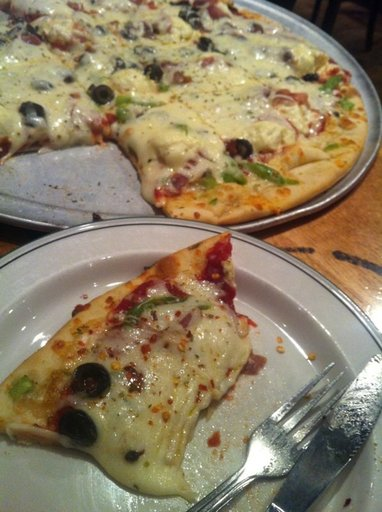

In [7]:
# Visualize the data

import random 
from PIL import Image

# random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

# Get the image class from path name
image_class = random_image_path.parent.stem

# Open the image
img = Image.open(random_image_path)

# Print img shape
print(img.size, type(img))

# Show the image
img



Image shape: (512, 382, 3)


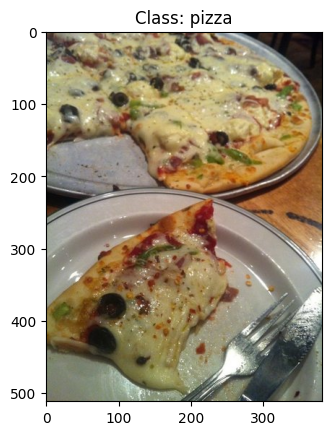

In [8]:
# Visualize the image using matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into array
img_as_arry = np.asarray(img)

# Plot the image
plt.imshow(img_as_arry)
plt.title(f"Class: {image_class}")
print(f"Image shape: {img_as_arry.shape}") # Height, Width, Channel

In [9]:
# Transforming data

from torch.utils.data import dataloader
from torchvision import datasets, transforms

In [10]:
# Write a transform for image

data_transform = transforms.Compose([
    # Resize the image to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the image
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into tensor
    transforms.ToTensor()
])
print(img.size) # NOTE: Use size to check the shape of the PIL image
print(data_transform(img).shape) # NOTE: !!!! The color channel is the first dimension

(382, 512)
torch.Size([3, 64, 64])


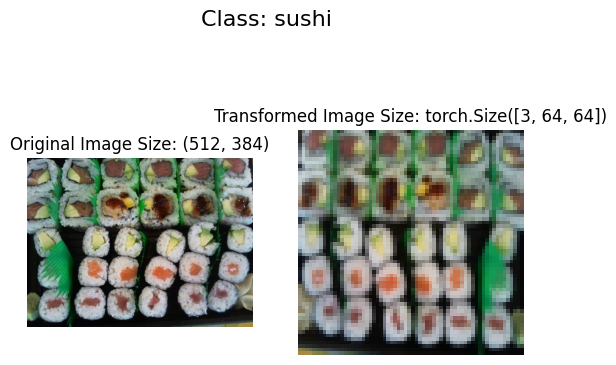

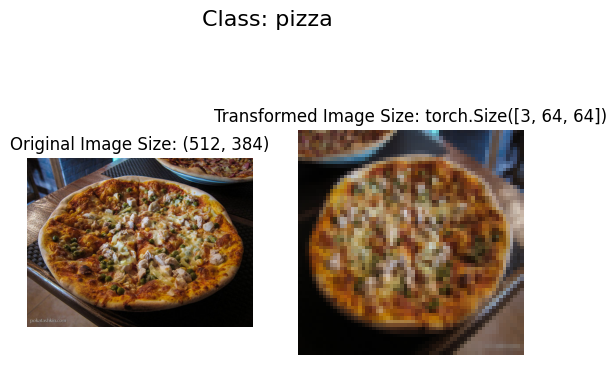

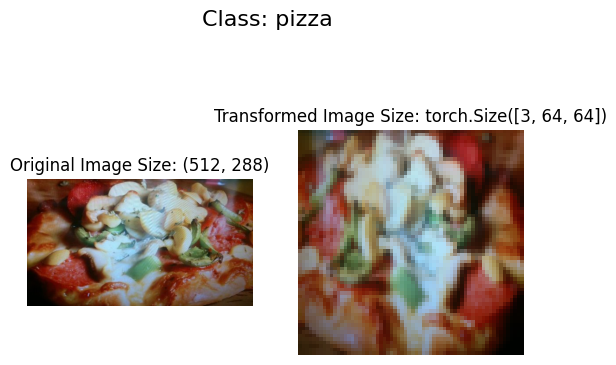

In [11]:
# Visualize the transformed image

def plot_transformed_image(image_paths, transform, n=3, seed=42):
    """
    Plot the transformed image
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as image:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(image)
            ax[0].set_title(f"Original Image Size: {image.size}")
            ax[0].axis("off")

            transformed_image = transform(image)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title(f"Transformed Image Size: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_image(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)



In [12]:
# Option 1: Loading image using "ImageFolder"

from torchvision import datasets

train_data = datasets.ImageFolder(root='data/pizza_steak_sushi/train',
                                  transform=data_transform,
                                  target_transform=None
                                )

test_data = datasets.ImageFolder(root='data/pizza_steak_sushi/test',
                                    transform=data_transform,
                                    target_transform=None
                                    )

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
# Get class names
class_names = train_data.classes
print(class_names)

# Check the length of the dataset
print(len(train_data)), 
print(len(test_data))

['pizza', 'steak', 'sushi']
225
75


In [14]:
img, label = train_data[0][0], train_data[0][1]
print(f" Image shape: {img.shape}")
print(f" Image type: {img.dtype}")
print(f" Label: {label}")
print(f" Label type: {type(label)}")

 Image shape: torch.Size([3, 64, 64])
 Image type: torch.float32
 Label: 0
 Label type: <class 'int'>


In [15]:
# Turn loaded images into Dataloader

from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_data,
                                batch_size=BATCH_SIZE,
                                num_workers=os.cpu_count(),
                                shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                                batch_size=BATCH_SIZE,
                                num_workers=os.cpu_count(),
                                shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fea05995590>,
 <torch.utils.data.dataloader.DataLoader at 0x7fea05c01c90>)

In [16]:
len(train_dataloader), len(test_dataloader)

(15, 5)

In [17]:
img, label = next(iter(train_dataloader))
print(f"Image batch shape: {img.size()}, Label batch shape: {label.size()}")

Image batch shape: torch.Size([16, 3, 64, 64]), Label batch shape: torch.Size([16])


#### Option 2: Loading images with Custom Dataset (without using PyTorch's ImageFolder)

Goal is to
- load images from filecmp
- get class names from a Dataset
- get classes as dictionary from the Dataset

Have a look at [the Tutorial Book](https://www.learnpytorch.io/04_pytorch_custom_datasets/#5-option-2-loading-image-data-with-a-custom-dataset:~:text=Woohoo!%20Looking%20good!-,5.2%20Create%20a%20custom%20Dataset%20to%20replicate%20ImageFolder,-%C2%B6)


### -> Checkout this NICE blog from PyTorch: 
[How to Train State-Of-The-Art Models Using TorchVision’s Latest Primitives](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements)

In [18]:
# Other forms of transforms

# Start with TrivialAgument, https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])

In [19]:
image_path

PosixPath('data/pizza_steak_sushi')

In [20]:
image_path_list = list(image_path.glob('*/**/*.jpg'))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/398345.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/971934.jpg')]

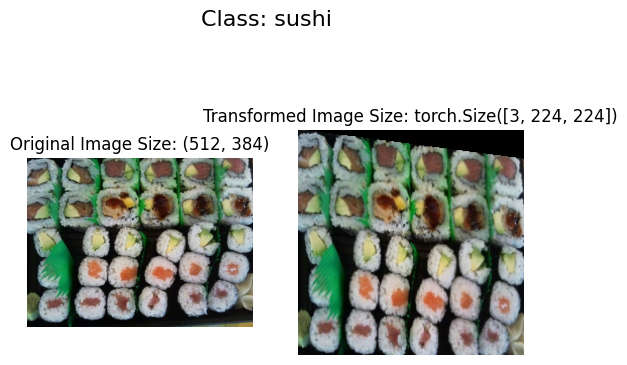

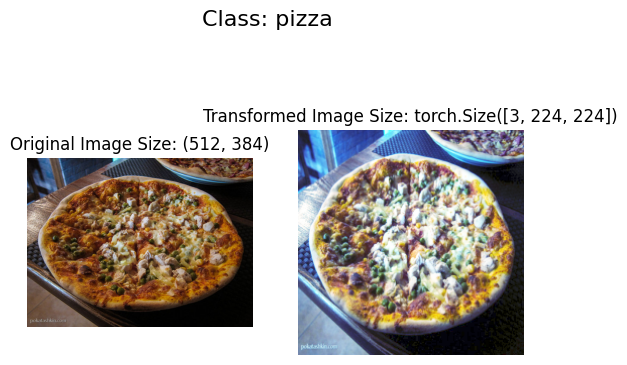

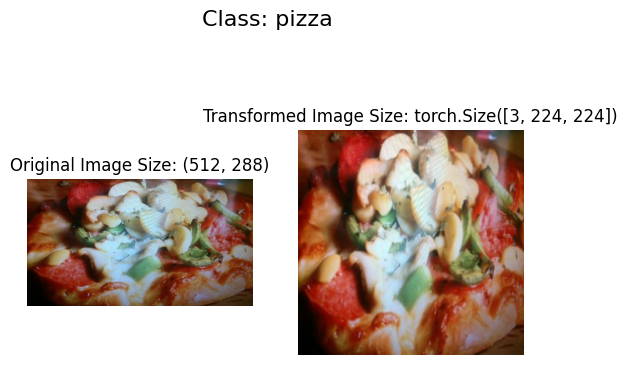

In [21]:
plot_transformed_image(image_paths=image_path_list,
                       transform=train_transform,
                       n=3)


### Building a baseline model
- Model0: TinyVGG

In [22]:
# Create a simple transform

simple_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [23]:
# Load and transform data

train_data_simple = datasets.ImageFolder(root='data/pizza_steak_sushi/train/',
                                         transform=simple_transform,
                                         target_transform=None,
                                         )

test_data_simple = datasets.ImageFolder(root='data/pizza_steak_sushi/test/',
                                        transform=simple_transform,
                                        target_transform=None,
                                        )

train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [24]:
# Create dataloaders
BATCH_SIZE = 32
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=os.cpu_count())

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=os.cpu_count())

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7fea66d25590>,
 <torch.utils.data.dataloader.DataLoader at 0x7fea66b7bf10>)

In [25]:
# Create a model

class Foodmini3V0(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56, 
                      out_features=output_size),
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f"Image size after conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Image size after conv_block_2: {x.shape}")
        x = self.classifier(x)
        # print(f"Image size after classifier: {x.shape}")
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # called operator fusion, faster than above: Link: check below for more info


- More info on [Operator fusion](https://horace.io/brrr_intro.html#:~:text=This%20is%20operator%20fusion%20%2D%20the%20most%20important%20optimization%20in%20deep%20learning%20compilers.%20Simply%20put%2C%20instead%20of%20writing%20our%20data%20to%20global%20memory%20just%20to%20read%20it%20again%2C%20we%20elide%20the%20extra%20memory%20accesses%20by%20performing%20several%20computations%20at%20once.)

In [26]:
model_0 = Foodmini3V0(input_size=3, 
                      hidden_units=10, 
                      output_size=3).to(device)

print(f"Model 0 architecture:\n{model_0}")

Model 0 architecture:
Foodmini3V0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=3, bias=True)
  )
)


In [27]:
# Check model 0 with dummy data

dummy_input = torch.randn(1, 3, 224, 224).to(device)

model_0(dummy_input)

tensor([[0.0434, 0.0403, 0.0230]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [28]:
# Use torchinfo to get model summary

from torchinfo import summary

summary(model=model_0, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Foodmini3V0                              [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 10, 224, 224]         280
│    └─ReLU: 2-2                         [1, 10, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 10, 224, 224]         910
│    └─ReLU: 2-4                         [1, 10, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 10, 112, 112]         --
├─Sequential: 1-2                        [1, 10, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 10, 112, 112]         910
│    └─ReLU: 2-7                         [1, 10, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 10, 112, 112]         910
│    └─ReLU: 2-9                         [1, 10, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 10, 56, 56]           --
├─Sequentia

In [29]:
# Loss, optimizer, and accuracy

from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

In [30]:
def print_train_time(start,
                     end,
                     device):
    
    total_time = end - start
    print(f'Training time on {device}: {total_time:.3f} seconds')
    return total_time

In [31]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               accuracy_fn,
               device: torch.device = device):

    train_loss, train_acc = 0, 0    

    # Put model in training mode
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        
        # move data to device
        X, y = X.to(device), y.to(device)

        # forward pass
        y_pred = model(X)

        # loss calculation (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() # accumulate train loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        # zero gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update weights 
        optimizer.step() # NOTE: updating weights for every batch, so model is learning from every batch

    # NOTE: now we are in epoch loop
    # Divide total train loss by length of dataloader
    train_loss /= len(dataloader)

    # Divide total train accuracy by length of dataloader
    train_acc /= len(dataloader)

    # Print
    # print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")

    return train_loss, train_acc

In [32]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
    
    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y, 
                                    y_pred=test_pred.argmax(dim=1)) # go from logits to prediction labels
            
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        # print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.3f}")

    return test_loss, test_acc

In [33]:
def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs):
    
    results = {"train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": []}

    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch}\n-------------------------------")
        train_loss, train_acc = train_step(model=model,
                dataloader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn,
                device=device)
        test_loss, test_acc = test_step(model=model,
                    dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    accuracy_fn=accuracy_fn,
                    device=device)
        
        print(f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}, Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [34]:
# Make prediction and visualize the result

torch.manual_seed(42)

def eval_model(model,
               dataloader,
               loss_fn,
               accuracy_fn):
    """
    Evaluate the model on the given data_loader with the given loss function
    """

    loss, acc = 0, 0

    with torch.inference_mode():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        loss /= len(dataloader)
        acc /= len(dataloader)

    return {"model_name" : model.__class__.__name__,
            "model_loss" : loss.item(),
            "model_acc" : acc}


In [35]:
# Write a training loop

from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10

train_time_start_model_2 = timer()

model_0_results = train(model=model_0,
      train_dataloader=train_dataloader_simple,
      test_dataloader=test_dataloader_simple,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      device=device,
      epochs=epochs)
    
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
-------------------------------


 10%|█         | 1/10 [00:01<00:15,  1.73s/it]

Epoch: 0, Train loss: 1.1165, Train accuracy: 35.9375, Test loss: 1.2293, Test accuracy: 26.0417
Epoch 1
-------------------------------


 20%|██        | 2/10 [00:03<00:13,  1.69s/it]

Epoch: 1, Train loss: 1.1100, Train accuracy: 42.5781, Test loss: 1.1494, Test accuracy: 26.0417
Epoch 2
-------------------------------


 30%|███       | 3/10 [00:05<00:11,  1.66s/it]

Epoch: 2, Train loss: 1.0799, Train accuracy: 42.5781, Test loss: 1.1325, Test accuracy: 26.0417
Epoch 3
-------------------------------


 40%|████      | 4/10 [00:06<00:10,  1.67s/it]

Epoch: 3, Train loss: 1.0916, Train accuracy: 30.4688, Test loss: 1.1141, Test accuracy: 28.1250
Epoch 4
-------------------------------


 50%|█████     | 5/10 [00:08<00:08,  1.67s/it]

Epoch: 4, Train loss: 1.0491, Train accuracy: 56.2500, Test loss: 1.1116, Test accuracy: 32.2917
Epoch 5
-------------------------------


 60%|██████    | 6/10 [00:10<00:06,  1.69s/it]

Epoch: 5, Train loss: 1.0496, Train accuracy: 44.1406, Test loss: 1.0356, Test accuracy: 31.2500
Epoch 6
-------------------------------


 70%|███████   | 7/10 [00:11<00:05,  1.68s/it]

Epoch: 6, Train loss: 0.9762, Train accuracy: 56.6406, Test loss: 1.0969, Test accuracy: 37.2159
Epoch 7
-------------------------------


 80%|████████  | 8/10 [00:13<00:03,  1.68s/it]

Epoch: 7, Train loss: 1.0055, Train accuracy: 51.9531, Test loss: 1.0400, Test accuracy: 33.3333
Epoch 8
-------------------------------


 90%|█████████ | 9/10 [00:15<00:01,  1.68s/it]

Epoch: 8, Train loss: 1.0393, Train accuracy: 43.7500, Test loss: 1.0821, Test accuracy: 34.2803
Epoch 9
-------------------------------


100%|██████████| 10/10 [00:16<00:00,  1.68s/it]

Epoch: 9, Train loss: 0.9897, Train accuracy: 45.3125, Test loss: 0.9346, Test accuracy: 59.3750
Training time on cuda: 16.757 seconds


In [36]:
# Plot the loss curve

def plot_loss_curves(results):
    # Get the loss values
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Get the epochs
    epochs = range(len(loss))

    # Setup a plot
    plt.figure(figsize=(12, 8))

    # Plot loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

#### -> Google guide on [Interpreting Loss Curves](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic)

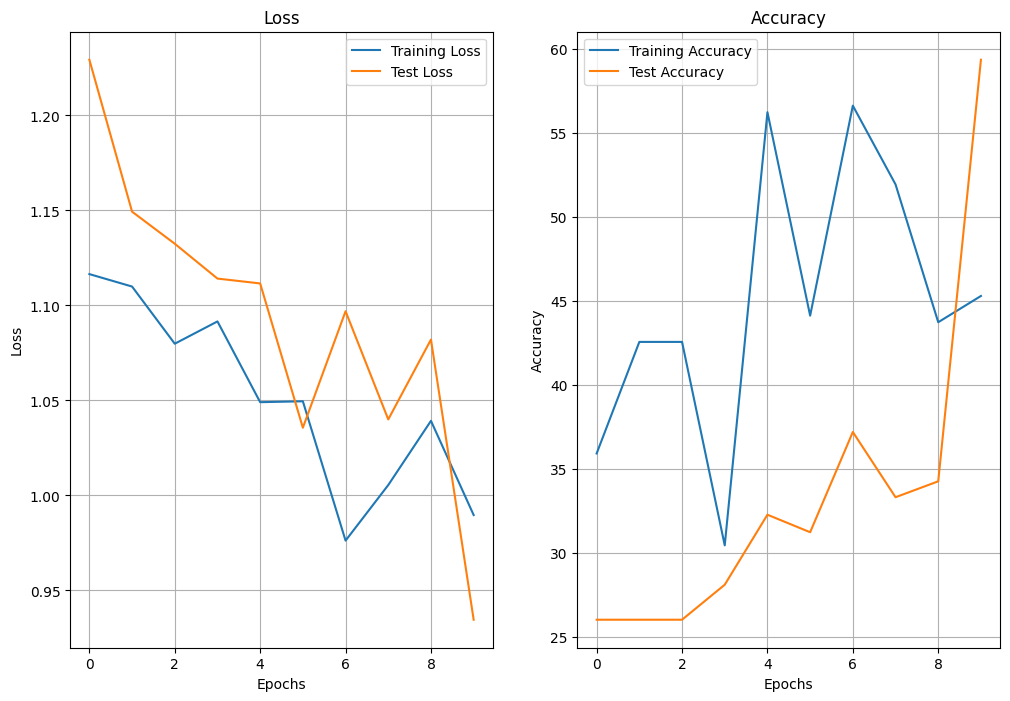

In [37]:
plot_loss_curves(model_0_results)

## Model 2 with Data Augmentation

In [38]:
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

In [39]:
# Load and transform data

train_data_trivial = datasets.ImageFolder(root='data/pizza_steak_sushi/train/',
                                         transform=train_transform_trivial,
                                         target_transform=None,
                                         )

test_data_simple = datasets.ImageFolder(root='data/pizza_steak_sushi/test/',
                                        transform=simple_transform,
                                        target_transform=None,
                                        )

train_data_trivial, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [40]:
# Create dataloaders
BATCH_SIZE = 32
train_dataloader_trivial = DataLoader(dataset=train_data_trivial,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=os.cpu_count())

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=os.cpu_count())

train_dataloader_trivial, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7fea66875590>,
 <torch.utils.data.dataloader.DataLoader at 0x7fea66c01c10>)

In [41]:
model_1 = Foodmini3V0(input_size=3, 
                      hidden_units=10, 
                      output_size=3).to(device)

print(f"Model 0 architecture:\n{model_1}")

Model 0 architecture:
Foodmini3V0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=3, bias=True)
  )
)


In [42]:
# Write a training loop

from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10

train_time_start_model_2 = timer()

model_1_results = train(model=model_1,
      train_dataloader=train_dataloader_trivial,
      test_dataloader=test_dataloader_simple,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      device=device,
      epochs=epochs)
    
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
-------------------------------


 10%|█         | 1/10 [00:01<00:14,  1.60s/it]

Epoch: 0, Train loss: 1.0993, Train accuracy: 28.1250, Test loss: 1.0966, Test accuracy: 54.1667
Epoch 1
-------------------------------


 20%|██        | 2/10 [00:03<00:13,  1.66s/it]

Epoch: 1, Train loss: 1.0996, Train accuracy: 28.1250, Test loss: 1.0966, Test accuracy: 54.1667
Epoch 2
-------------------------------


 30%|███       | 3/10 [00:04<00:11,  1.67s/it]

Epoch: 2, Train loss: 1.0994, Train accuracy: 28.1250, Test loss: 1.0966, Test accuracy: 54.1667
Epoch 3
-------------------------------


 40%|████      | 4/10 [00:06<00:10,  1.70s/it]

Epoch: 3, Train loss: 1.0987, Train accuracy: 28.1250, Test loss: 1.0966, Test accuracy: 54.1667
Epoch 4
-------------------------------


 50%|█████     | 5/10 [00:08<00:08,  1.70s/it]

Epoch: 4, Train loss: 1.0994, Train accuracy: 28.1250, Test loss: 1.0966, Test accuracy: 54.1667
Epoch 5
-------------------------------


 60%|██████    | 6/10 [00:10<00:06,  1.70s/it]

Epoch: 5, Train loss: 1.0990, Train accuracy: 28.1250, Test loss: 1.0966, Test accuracy: 54.1667
Epoch 6
-------------------------------


 70%|███████   | 7/10 [00:11<00:05,  1.70s/it]

Epoch: 6, Train loss: 1.0985, Train accuracy: 28.1250, Test loss: 1.0966, Test accuracy: 54.1667
Epoch 7
-------------------------------


 80%|████████  | 8/10 [00:13<00:03,  1.69s/it]

Epoch: 7, Train loss: 1.0995, Train accuracy: 28.1250, Test loss: 1.0966, Test accuracy: 54.1667
Epoch 8
-------------------------------


 90%|█████████ | 9/10 [00:15<00:01,  1.69s/it]

Epoch: 8, Train loss: 1.0976, Train accuracy: 40.2344, Test loss: 1.0966, Test accuracy: 54.1667
Epoch 9
-------------------------------


100%|██████████| 10/10 [00:16<00:00,  1.69s/it]

Epoch: 9, Train loss: 1.0995, Train accuracy: 28.1250, Test loss: 1.0966, Test accuracy: 54.1667
Training time on cuda: 16.862 seconds


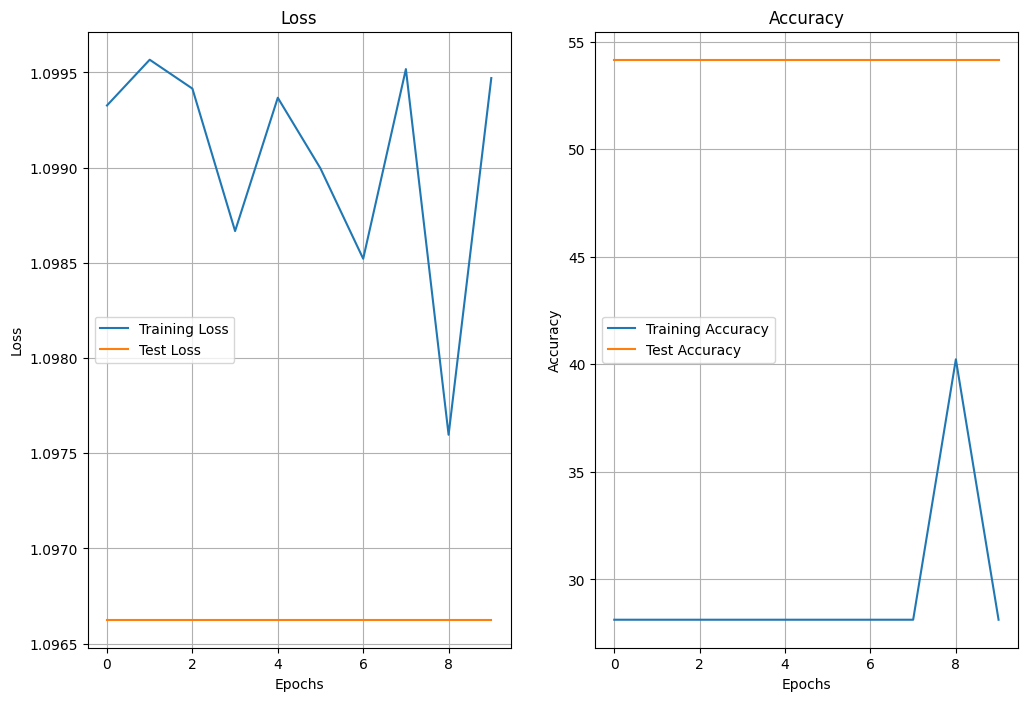

In [43]:
plot_loss_curves(model_1_results)

### Make prediction on custom image

In [44]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [45]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [47]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

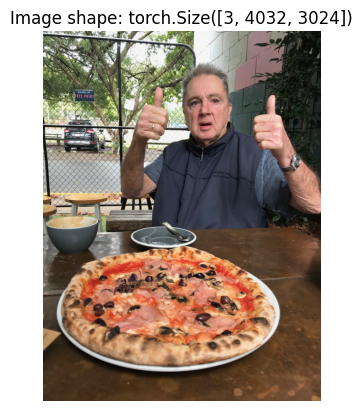

In [48]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [49]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 224, 224])


/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [50]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [51]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 224, 224])
Unsqueezed custom image shape: torch.Size([1, 3, 224, 224])


```txt
Note: What we've just gone through are three of the classical and most common deep learning and PyTorch issues:

- [Wrong datatypes] - our model expects torch.float32 where our original custom image was uint8.
- [Wrong device] - our model was on the target device (in our case, the GPU) whereas our target data hadn't been moved to the target device yet.
- [Wrong shapes] - our model expected an input image of shape [N, C, H, W] or [batch_size, color_channels, height, width] whereas our custom image tensor was of shape [color_channels, height, width].
Keep in mind, these errors aren't just for predicting on custom images.

They will be present with almost every kind of data type (text, audio, structured data) and problem you work with.
```

In [54]:
from typing import List

def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


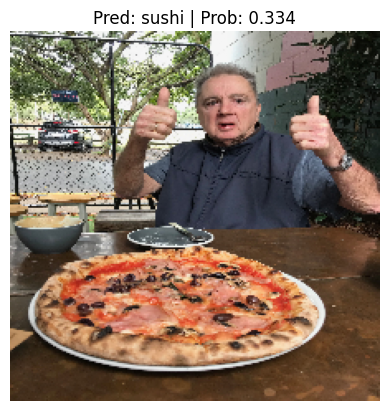

In [55]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)